In [1]:
using Plots, ForwardDiff, Random, LinearAlgebra, RDST, Distributions, OnlineStats, BenchmarkTools

using Flux, MLDatasets, ImageCore, Colors

using Sofia

# For using package modified in local repo 
using Pkg

push!(LOAD_PATH, "C://Users//jerem//OneDrive//Desktop//GitHub//Code//FinalCode")

using Geraldine

┌ Info: Precompiling Geraldine [c0fffcf4-b2fb-46e8-8a34-03ca56aefa66]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken fo

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

┌ Warning: Package Geraldine does not have Pkg in its dependencies:
│ - If you have Geraldine checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Geraldine
└ Loading Pkg into Geraldine from project dependency, future warnings for Geraldine are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



# Data 

In [2]:
abstract type MnistData{T, S} end

In [3]:
using MLDatasets: MNIST

### Structure Data
mutable struct MnistDataMLP{T, S} <: MnistData{T, S}
    x::Array{T,2}
    y::Array{S,1}
    oneHoty::Matrix{T}
    
    sizeSAA::Int

    function MnistDataMLP{T, S}(xdata, ydata; sizeSAA::Int=1, shuffled::Bool=false) where {T, S}
        oneHoty = Matrix{T}(undef, 10, length(ydata))
        if (shuffled)
            shuffled_indices = randperm(MersenneTwister(1234), size(xdata, 2))
            x = Array{T, 2}(undef, size(xdata))
            y = Array{S, 1}(undef, size(ydata))
            for (k, j) in enumerate(shuffled_indices)
                x[:, k] = xdata[:, j]
                y[k] = ydata[j]
                oneHoty[:,k] = Array{T}(Flux.onehot(ydata[k], 1:10))
            end
            return new{T, S}(x, y, oneHoty, sizeSAA)
        else
             for k in 1:length(ydata) 
                oneHoty[:,k] = Array{T}(Flux.onehot(ydata[k], 1:10))
            end
            return new{T, S}(xdata, ydata, oneHoty, sizeSAA)
        end
    end
end

In [4]:
### Data:
# Load MNIST data (par batch de 1 pour pourvoir faire du SAA)
xtrn_,ytrn = MNIST.traindata(Float64);
ytrn[ytrn.==0] .= 10 # pour changer les labels 0 en 10

xtst_,ytst = MNIST.testdata(Float64);
ytst[ytst.==0] .= 10 # pour changer les labels 0 en 10;

In [5]:
MLDatasets.MNIST.convert2image(xtrn_[:,:,5]; black_digits=true)

In [6]:
Gray.(xtrn_[:,:,5]')

In [7]:
_height, _width , ntrain_origin = size(xtrn_)
ntest_origin = size(xtst_ , 3)

# on veut reformer le dataset des images en (x_1 | ...| x_n) avec n=60000
#   --> reshape(784,60000) car 28x28 = 784
feature_size = _height*_width
xtrn = reshape(xtrn_ , (feature_size , ntrain_origin))
xtst = reshape(xtst_ , (feature_size , ntest_origin))

# Data finale
dtrn = MnistDataMLP{Float64, Int64}(xtrn, ytrn, shuffled=false)
dtst = MnistDataMLP{Float64, Int64}(xtst, ytst, sizeSAA = length(ytst))

dtrnFlux = MnistDataMLP{Float32, Int64}(xtrn, ytrn, shuffled=false)
dtstFlux = MnistDataMLP{Float32, Int64}(xtst, ytst, sizeSAA = length(ytst))

# Definition des nInd
const nInd = size(ytrn, 1)
const nInd_tst = size(ytst, 1)

10000

In [8]:
ind = 12
Gray.(xtrn_[:,:,ind])

In [9]:
Gray.(reshape(xtrn[:, ind], 28, 28))

In [10]:
sample = 1:10000

X = dtrn.x[:, sample]
Y = dtrn.y[sample]
Yhot = dtrn.oneHoty[:, sample]

10×10000 Array{Float64,2}:
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0

In [11]:
ind = 1000

@show dtrn.y[ind]
@show dtrn.oneHoty[:,ind]

Gray.(reshape(dtrn.x[:, ind], 28, 28)')

dtrn.y[ind] = 6
dtrn.oneHoty[:, ind] = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


# My MLP

## -- Activation functions

In [12]:
abstract type AbstractActivation end

In [13]:
abstract type AbstractRealActivation <: AbstractActivation end

abstract type AbstractVectorActivation <: AbstractActivation end

In [14]:
struct IdentityActivation{T} <: AbstractRealActivation
    f::Function # activation function
    g::Function # derivative
    h::Function # second derivative
    function IdentityActivation{T}() where T
        f = (x::Real -> T(x) )
        g = (x::Real -> one(T))
        h = (x::Real -> zero(T))
        return new(f, g, h)
    end
    
    IdentityActivation() = IdentityActivation{Float64}()
end

In [15]:
x = collect(-5.0:0.1:5.0);

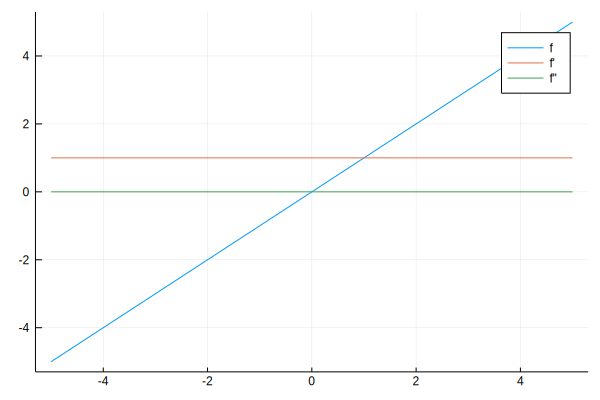

In [16]:
sig = IdentityActivation{Float64}()

plot(x, sig.f.(x), label="f")
plot!(x, sig.g.(x), label="f'")
plot!(x, sig.h.(x), label="f''")

In [17]:
struct sigmoidActivation{T} <: AbstractRealActivation
    f::Function # activation function
    g::Function # derivative
    h::Function # second derivative
    function sigmoidActivation{T}() where T
        f = (x::Real -> T(1/(1+exp(-x))) )
        g = (x::Real -> T(f(x)^2*exp(-x)))
        h = (x::Real -> T(-exp(-x)*f(x)^2 + 2*exp(-2*x)*f(x)^3))
        return new(f, g, h)
    end
    
    sigmoidActivation() = sigmoidActivation{Float64}()
end



In [18]:
struct sigmoidActivation{T} <: AbstractRealActivation
    function sigmoidActivation{T}() where T
        f = 
        g = (x::Real -> T(f(x)^2*exp(-x)))
        h = (x::Real -> T(-exp(-x)*f(x)^2 + 2*exp(-2*x)*f(x)^3))
        return new(f, g, h)
    end
    
    sigmoidActivation() = sigmoidActivation{Float64}()
end

# function f(::Type{sigmoidActivation{T}}, x::Real) where T
#    return T(1/(1+exp(-x)))  
# end

LoadError: [91minvalid redefinition of constant sigmoidActivation[39m

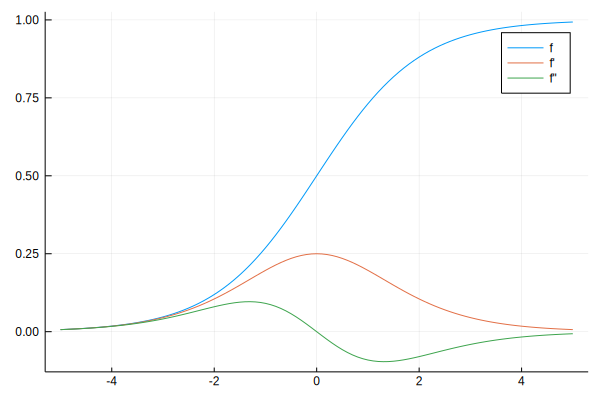

In [19]:
sig = sigmoidActivation{Float64}()

plot(x, sig.f.(x), label="f")
plot!(x, sig.g.(x), label="f'")
plot!(x, sig.h.(x), label="f''")

In [20]:
struct tanhActivation{T} <: AbstractRealActivation
    f::Function # activation function
    g::Function # derivative
    h::Function # second derivative
    function tanhActivation{T}() where T 
        f = (x::Real -> T( (1 - exp(-2*x))/(1 + exp(-2*x)) ) )
        
        sigDev = (x::Real -> exp(-x)/(1 + exp(-x))^2)
        g = (x::Real -> T(2*( sigDev(2*x) + sigDev(-2*x) )))
        sigDevSec = (x::Real -> -exp(-x)/(1 + exp(-x))^2 + 2*exp(-2*x)/(1 + exp(-x))^3)
        h = (x::Real -> T(4*( sigDevSec(2*x) - sigDevSec(-2*x) )))
        return new(f, g, h)
    end
    
    tanhActivation() = tanhActivation{Float64}()
end

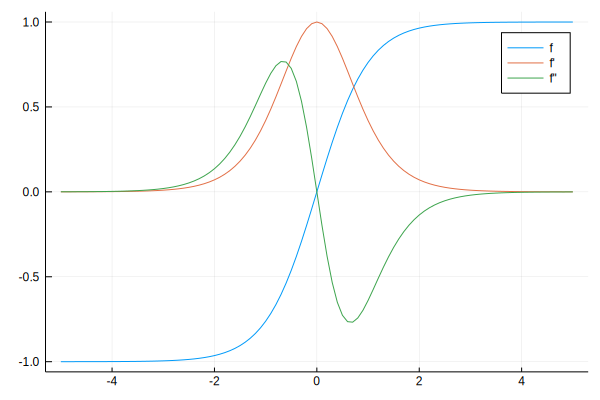

In [21]:
sig = tanhActivation{Float64}()

plot(x, sig.f.(x), label="f")
plot!(x, sig.g.(x), label="f'")
plot!(x, sig.h.(x), label="f''")

In [22]:
struct ReLUActivation{T} <: AbstractRealActivation
    f::Function # activation function
    g::Function # derivative
    h::Function # second derivative
    function ReLUActivation{T}() where T
        f = (x::Real -> x <= 0.0 ? zero(T) : T(x))
        g = (x::Real -> x <= 0.0 ? zero(T) : T(1.0))
        h = (x::Real -> zero(T))
        return new(f, g, h)
    end
    
    ReLUActivation() = ReLUActivation{Float64}()
end

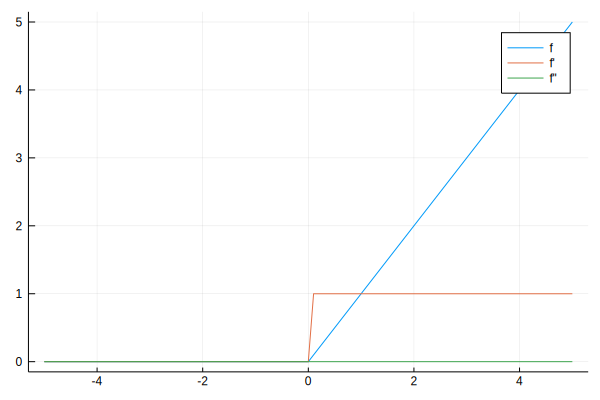

In [23]:
sig = ReLUActivation{Float64}()

plot(x, sig.f.(x), label="f")
plot!(x, sig.g.(x), label="f'")
plot!(x, sig.h.(x), label="f''")

In [24]:
struct SoftPlusActivation{T} <: AbstractRealActivation
    f::Function # activation function
    g::Function # derivative
    h::Function # second derivative
    function SoftPlusActivation{T}() where T
        f = (x::Real -> log(1 + exp(x)))
        g = (x::Real -> T(1/(1 + exp(-x))))
        h = (x::Real -> T(g(x)^2*exp(-x)))
        return new(f, g, h)
    end
    
    SoftPlusActivation() = SoftPlusActivation{Float64}()
end

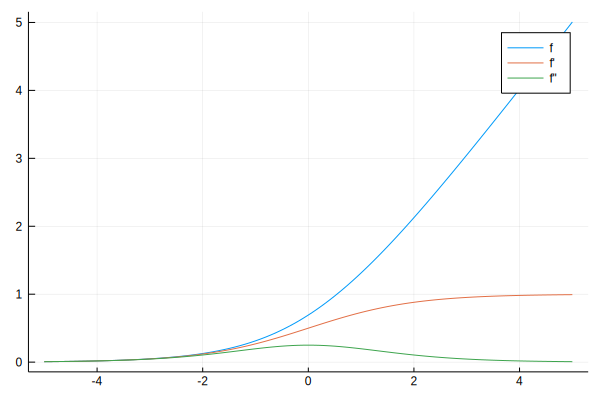

In [25]:
sig = SoftPlusActivation{Float64}()

plot(x, sig.f.(x), label="f")
plot!(x, sig.g.(x), label="f'")
plot!(x, sig.h.(x), label="f''")

$$ H_{\mathcal{M}_i} = \dfrac{1}{p_i}\nabla \mathcal{M}_i \nabla \mathcal{M}_i^T - p_i J_{ \mathcal{M}_i}  $$

In [31]:
struct SoftMaxActivation{T} <: AbstractVectorActivation
    f::Function
    Jac::Function
    Hs::Function
    
    function SoftMaxActivation{T}() where T
        function f(x::Vector{T})
            all_exp = Array{T}(exp.(x))
            return all_exp./sum(all_exp)        
        end
        function Jac(x::Vector{T})
            p =  Array{T}(f(x))
            return Diagonal(p) - p*p'
        end
        
        function Hs(x::Vector{T})
            dim = length(x)
            
            all_h = Array{Matrix{T}}(undef, dim)
            p =  Array{T}(f(x))
            J = Jac(x)
            for i in 1:dim
               all_h[i] = (1/p[i])*J[:,i]*J[:,i]' + p[i]*J 
            end
            return all_h
        end
        
        return new(f, Jac, Hs)
    end
    
    SoftMaxActivation() = SoftMaxActivation{Float64}()
end

In [32]:
struct IdentityVecActivation{T} <: AbstractVectorActivation
    f::Function
    Jac::Function
    
    function IdentityVecActivation{T}() where T
        function f(x::Vector{T})
            return x     
        end
        function Jac(x::Vector{T})
            return Matrix{Float64}(I, length(x), length(x))
        end
        return new(f, Jac)
    end
    
    IdentityVecActivation() = IdentityVecActivation{Float64}()
end

## -- Losses

In [33]:
abstract type AbstractLoss{T} end

struct CrossEntropyLoss{T} <: AbstractLoss{T}
    f::Function 
    g::Function
    h::Function
    function CrossEntropyLoss{T}() where T
       function f(target::Vector{T}, proba::Vector{T})
           return -dot(target, log.(proba))
        end
        function g(target::Vector{T}, proba::Vector{T})
            return -target./proba
        end
        function h(target::Vector{T}, proba::Vector{T})
           return Diagonal(target./(proba.^2)) 
        end
        return new{T}(f, g, h)
    end
end

## -- Neural Network

In [34]:
"""
Multilayer Perceptron
Cost function : Cross-Entropy + L2 regularization
Activation function : ReLU (or Sigmoïd)
Output function : Softmax
Labels structure : One-hot encoding
Weights initilization : Normal(0,1/sqrt(sizes[l]))
"""
#--------------         Structure Network -------------------------
# -- premiere couche : vecteurs entree
# -- derniere couche : probabilites de chaque label avec SoftMax

mutable struct NeuralNetwork{T}
    
    dimIn::Int
    dimOut::Int
    nbLayers::Int
    nbHiddenLayers::Int64 # -- nombre couche reseau : au minimum 2 , input / output
    
    sizeLayers::Array{Int64}
    sizeHiddenLayers::Array{Int64} 
    
    dim::Int # total number of parameters in Neural Network
    
    activationFunctions::Array{AbstractActivation, 1}
    nonLinearity::AbstractVectorActivation
    
    weights::Array{Matrix{T}} # -- tableau de matrices : 1 matrice represente
                                    #    les poids w_ij pour passer d'une couche a l'autre
                                    # il y aura num_layers-1 matrices de poids
    
    gradF_aL::Array{Matrix{T}}
    gradF_sL::Array{Matrix{T}}
    
    index::Array # -- Pour conaitre les tranches d'indices correspondant à chaque couche,
                 #      lors de la représentation des paramètres en vecteur
    indexW::Array
    indexb::Array
    
    a::Array{Matrix{T}} # -- valeur d'Activation de chaque neurone
                              # a est un tableau de matrices :
                              #     - a[l] = matrice des valeurs des neurones pour couche l
                              # pour chaque matrice M :
                              #     - colonne M[:,j] --> valeur des neurones avec data j
                              # a[m][:,j] = valeurs des neurones couche m avec entree x_j
                              # Derniere colonne = (1 1 ... 1)^T pour prendre en compte
                              # addition du biais
    
    δ::Matrix{T} # -- pour backpropagation : represente ∇f_i(β) w.r.t. a(L)
                                                    # où L couche en cours
    λ::T # -- Pour L2-regularization

    # ------------ Constructeur Network ---------------
    # -- sizes : tableau dimension chaque couche --> input / hidden / Output
    # -- λ : facteur regularisation
    # -- n_total : taille population
    # -- seed
    function NeuralNetwork{T}(sizeLayers::Array{Int64}, nSamples::Int64;
                                activationFunctions::Array{AbstractActivation}= AbstractActivation[],
                                λ::T = T(0.0),
                                seed::Int64=1234) where T
    
        network = new{T}()
        
        network.dimIn = sizeLayers[1]
        network.dimOut = sizeLayers[end]
        network.nbLayers = length(sizeLayers)
        network.nbHiddenLayers = network.nbLayers - 2
        
        network.sizeLayers = sizeLayers
        if network.nbHiddenLayers == 0 
            network.sizeHiddenLayers = Int64[]
        else
            network.sizeHiddenLayers = sizeLayers[2:network.nbLayers-1]
        end
        # Calcul dim vector parameters
        network.dim = 0
        for k in 1:length(sizeLayers)-1
            network.dim += (sizeLayers[k]+1)*sizeLayers[k+1]
        end
        
        network.index = Array{UnitRange{Int64}}(undef, network.nbLayers-1)
        network.indexW = Array{UnitRange{Int64}}(undef, network.nbLayers-1)
        network.indexb = Array{UnitRange{Int64}}(undef, network.nbLayers-1)
        if seed > 0
            mrg_gen = MRG32k3aGen([seed for i = 1:6])
            mrg = next_stream(mrg_gen)
            network.weights = Array{Matrix{T}}(undef, network.nbLayers-1)
            for k = 1:network.nbLayers-1 # -- Initialisation des poids
                next_substream!(mrg)
                nIn = sizeLayers[k]
                nOut = sizeLayers[k+1]
                bound = sqrt(6.0/(nIn + nOut))
                network.weights[k] = Matrix{T}(hcat(rand(Uniform(-bound, bound), nOut, nIn), zeros(nOut, 1)))
            end
        else
            # zip cree l'ensemble des couples (h , h+1) pour passage d'une couche a l'autre
            # (j , i+1) : le +1 est pour le biais
            network.weights = [zeros(T, j, i+1) for (i,j) in zip(sizeLayers[1:network.nbLayers-1], sizeLayers[2:network.nbLayers])]
        end
        
        network.gradF_aL = Array{Matrix{T}}(undef, network.nbLayers - 1)
        network.gradF_sL = Array{Matrix{T}}(undef, network.nbLayers - 1)
        
        for k = 1:network.nbLayers-1              
            # Calcul pour index reference
            # Pour passer de la couche L-1 a L, il y a besoin de (size(L-1)+1)*size(L) indices
            # On index[k] contient tranches indices pour passer de k a k+1
            network.index[k] = (k==1 ? 1 : network.index[k-1][end]+1):(k==1 ? 0 : network.index[k-1][end])+(sizeLayers[k]+1)*sizeLayers[k+1]
            network.indexW[k] = (k==1 ? 1 : network.index[k-1][end]+1):(k==1 ? 0 : network.index[k-1][end])+ sizeLayers[k]*sizeLayers[k+1]
            network.indexb[k] = network.indexW[k][end]+1:network.indexW[k][end]+ sizeLayers[k+1]
        end
        
        # --- activation Functions
        if length(activationFunctions) > 0
            @assert length(activationFunctions) == network.nbLayers-1
            network.activationFunctions = activationFunctions 
        else
            network.activationFunctions = [IdentityActivation{T}() for i in 1:network.nbLayers-1]
        end
#         network.nonLinearity = ,nonLinearity
        
        # --- on initialise toutes les activites de neurone à 1 ----
        # enumerate(sizes) =  { (1, sizes[1]) ; (2,sizes[2]) ; ... }
        # +1 pour les couches intermediaires : pour ajouter le biais
        # +0 pour derniere couche : pas de biais
        network.a = [ones(T, j + (i==length(sizeLayers) ? 0 : 1), nSamples) for (i,j) in enumerate(sizeLayers)]
#         network.a = Matrix{T}[]
        
        network.δ = zeros(maximum(sizeLayers), nSamples)
        network.λ = λ
        return network
    end # fin Constructeur
end


In [35]:
function matrixToVec(N::NeuralNetwork{T}) where T
    u = vec(N.weights[1])
    for i in 2:N.nbLayers-1
       u = cat(u, vec(N.weights[i]), dims = 1) 
    end
    return u
end

matrixToVec (generic function with 1 method)

In [36]:
#------------------     feedforward!        ---------------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
#           - # lignes = # vecteur entree
#           - # colonne = taille echantillon
#           - X[:,j] = vecteur entree sous individu j
function feedforward!(N::NeuralNetwork, β::AbstractArray, X::AbstractArray)
    for i = 1:N.nbLayers-1
        N.weights[i][:,:] = reshape(β[N.index[i]], size(N.weights[i]))
        # on remet la partie du vecteur parame/ tres correspondant passage i a i+1
        # sous forme de matrice en remplissant colonne par colonne de haut en bas
    end
    nbInd = size(X, 2) # n = nombre individus dans echantillon
    
    # Forme compacte des couches d'activité
#     N.a = [ones(T, j + (i==length(N.sizeLayers) ? 0 : 1), nbInd) for (i,j) in enumerate(N.sizeLayers)]
    N.a[1][1:end-1,1:nbInd] = copy(X) # on initialise premiere couche avec vecteurs entree
    
    for l = 1:N.nbLayers-2
        N.a[l+1][1:end-1, 1:nbInd] = N.activationFunctions[l].f.(N.weights[l]*N.a[l][:, 1:nbInd])
    end
    N.a[end][:, 1:nbInd] = N.activationFunctions[end].f.(N.weights[end]*N.a[end-1][:, 1:nbInd])
    
end

feedforward! (generic function with 1 method)

# My model

In [37]:
################################################################################
#                Model for Mnist
################################################################################
mutable struct MnistModel{T, S} <: Sofia.AbstractStochasticModel{NotUpdatable}
    network::NeuralNetwork{T}
    x0::Vector{T}
    
    nonLinearity::AbstractVectorActivation
    loss::AbstractLoss{T}

    train_data::MnistData{T, S}
    test_data::MnistData{T, S}

    function MnistModel(network::NeuralNetwork{T}, x0::Vector{T}, tr_data::MnistData{T, S}, tst_data::MnistData{T, S}; 
                            nonLinearity::AbstractVectorActivation = IdentityVecActivation{T}(),
                            loss::AbstractLoss = CrossEntropyLoss{T}()) where {T, S}
        return new{T,S}(network, copy(x0), nonLinearity, loss, tr_data, tst_data)
    end

end

In [82]:
# My model 
layers = [784 ;  10]

activations = Array{AbstractActivation}([IdentityActivation{Float64}()])

n = NeuralNetwork{Float64}(layers, nInd, activationFunctions=activations);

println("dim total : ", n.dim)
println("dim In : ",n.dimIn)
println("dim Out : ",n.dimOut)
println("nb layers : ",n.nbLayers)
println("Sizes : ",n.sizeLayers)
println("nb Hidden : ",n.nbHiddenLayers)
println("Sizes Hidden : ",n.sizeHiddenLayers)

for k in 1:length(n.index)
    println(n.index[k])
    println("index W : ", n.indexW[k])
    println("index b ", n.indexb[k])
end 

for k in 1:length(n.weights)
    println(size(n.weights[k]))
end

for k in 1:length(n.activationFunctions)
   println(n.activationFunctions[k]) 
end

dim total : 7850
dim In : 784
dim Out : 10
nb layers : 2
Sizes : [784, 10]
nb Hidden : 0
Sizes Hidden : Int64[]
1:7850
index W : 1:7840
index b 7841:7850
(10, 785)
IdentityActivation{Float64}(var"#3#6"{Float64}(), var"#4#7"{Float64}(), var"#5#8"{Float64}())


In [83]:
mnist = MnistModel(n, matrixToVec(n), dtrn, dtst;  nonLinearity = SoftMaxActivation{Float64}() );

## Backpropagation

In [84]:
#-----------------------         backpropagation_all        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function backpropagation_all(N::NeuralNetwork{T}, β::AbstractArray, δ::Matrix{T}) where T
    nInd = size(δ, 2)
    all_grads = Matrix{T}(undef, N.dim, nInd)  
    
    N.gradF_aL[N.nbLayers-1] = copy(δ)
    for l = N.nbLayers:-1:2 
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        N.gradF_sL[l-1] = N.activationFunctions[l-1].g.(s_l).*N.gradF_aL[l-1]
#         println(size(N.gradF_sL[l-1]))
#         println(norm(N.gradF_sL[l-1]))
        for i in 1:nInd
            all_grads[N.index[l-1], i:i] = vec(N.gradF_sL[l-1][:,i]*transpose(N.a[l-1][:, i]))
        end
        if l>2
            N.gradF_aL[l-2] = transpose(N.weights[l-1][:, 1:end-1])*N.gradF_sL[l-1]
        end
    end
    return all_grads
end

backpropagation_all (generic function with 1 method)

In [85]:
#-----------------------         backpropagation        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function backpropagation(N::NeuralNetwork{T}, β::AbstractArray, δ::Matrix{T}) where T
    nInd = size(δ, 2)
    grad = Vector{T}(undef, N.dim)  
    
    N.gradF_aL[N.nbLayers-1] = copy(δ)
    for l = N.nbLayers:-1:2 
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        N.gradF_sL[l-1] = N.activationFunctions[l-1].g.(s_l).*N.gradF_aL[l-1]
#         println(size(N.gradF_sL[l-1]))
#         println(norm(N.gradF_sL[l-1]))
        grad[N.index[l-1]] = vec(N.gradF_sL[l-1]*transpose(N.a[l-1][:, 1:nInd]))
        
        if (l > 2 )
            N.gradF_aL[l-2] = transpose(N.weights[l-1][:, 1:end-1])*N.gradF_sL[l-1]
        end
    end
    return T(1/nInd)*grad
end

backpropagation (generic function with 1 method)

In [86]:
#-----------------------         backpropagation!        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function backpropagation!(N::NeuralNetwork{T}, all_grads::Matrix{T}, β::AbstractArray, δ::Matrix{T}) where T
    nInd = size(δ, 2)

    @assert size(all_grads) = (N.dim, nInd)
    
    gradF_aL = copy(δ)
    for l = N.nbLayers:-1:2 
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        gradF_sl = N.activationFunctions[l-1].g.(s_l).*gradF_aL
        for i in 1:nInd
            all_grads[N.index[l-1], i:i] = vec(gradF_sl[:,i]*transpose(N.a[l-1][:, i]))
        end
        gradF_aL = transpose(N.weights[l-1][:, 1:end-1])*gradF_sl
    end
end

backpropagation! (generic function with 1 method)

In [87]:
#-----------------------         backpropagation_mat        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function backpropagation_mat(N::NeuralNetwork{T}, β::AbstractArray, δ::Matrix{T}) where T
    nInd = size(δ, 2)
    all_grads = Matrix{T}(undef, N.dim, nInd)  

    gradF_aL = copy(δ)
    for l = N.nbLayers:-1:2 
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        gradF_sl = N.activationFunctions[l-1].g.(s_l).*gradF_aL
        
        na = size(N.a[l-1], 1)
        ngrad = size(gradF_sl, 1)
        offset = N.index[l-1][1]
        
        for i in 1:na
            start = (i-1)*ngrad + offset
            finish = i*ngrad + offset - 1
            all_grads[start:finish, 1:nInd] = gradF_sl[:, 1:nInd]*Diagonal(N.a[l-1][i, 1:nInd])
        end
        gradF_aL = transpose(N.weights[l-1][:, 1:end-1])*gradF_sl
    end
    return all_grads
end


backpropagation_mat (generic function with 1 method)

In [88]:
#-----------------------         backpropagation_mat!        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function backpropagation_mat!(N::NeuralNetwork{T}, all_grads::Matrix{T}, β::AbstractArray, δ::Matrix{T}) where T
    nInd = size(δ, 2)
    @assert size(all_grads) == (N.dim, nInd)

    gradF_aL = copy(δ)
    for l = N.nbLayers:-1:2 
#         println("l = ", l)
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        gradF_sl = N.activationFunctions[l-1].g.(s_l).*gradF_aL
        
        na = size(gradF_sl, 1)
        offset = N.index[l-1][1]
        
        for i in 1:na
            start = (i-1)*na + offset
            finish = i*na + offset - 1
            all_grads[start:finish, 1:nInd] = gradF_sl[:, 1:nInd]*Diagonal(N.a[l-1][i, 1:nInd])
        end
        gradF_aL = transpose(N.weights[l-1][:, 1:end-1])*gradF_sl
    end
end


backpropagation_mat! (generic function with 1 method)

## Definition of functions

In [89]:
nInd = 60000
mysample = 1:nInd

feedforward!(mnist.network, matrixToVec(mnist.network), mnist.train_data.x[:, mysample])
    
# Loss Derivative
δ = Matrix{Float64}(undef, mnist.network.dimOut, length(mysample))
for (j, ind) in enumerate(mysample)
    aL = mnist.network.a[end][:, j]
    p = mnist.nonLinearity.f(aL)
    δ[:, j] = transpose(mnist.nonLinearity.Jac(aL))*mnist.loss.g(mnist.train_data.oneHoty[:, ind], p)
end

δ

10×60000 Array{Float64,2}:
  0.0654092   0.0982054   0.159082   …   0.115086    0.104749    0.131137
  0.0691      0.0984872   0.0767487      0.125393    0.114223    0.167506
  0.0788025   0.102173    0.0534709      0.0609855   0.127202    0.0644775
  0.076932    0.0661652  -0.91679        0.0986578   0.0662356   0.0719615
 -0.943731    0.0543953   0.110151      -0.951804    0.0511719   0.064987
  0.180269    0.151957    0.113135   …   0.151906   -0.923229    0.142721
  0.0867903   0.0872322   0.0802298      0.0759821   0.113251    0.0429238
  0.057075    0.0507239   0.115564       0.054418    0.0835983  -0.917278
  0.187964    0.130172    0.107136       0.188345    0.15927     0.170768
  0.141389   -0.83951     0.101272       0.0810309   0.103527    0.0607956

In [90]:
function Sofia.Nobs(mo::MnistModel)
   return length(mo.train_data.y)
end

@show Nobs(mnist)

Nobs(mnist) = 60000


60000

In [91]:
function Sofia.Fs(beta::AbstractArray, mo::MnistModel ; sample=1:Nobs(mo))
    X = mo.train_data.x[:,sample]
    Y = mo.train_data.oneHoty[:, sample]
    feedforward!(mo.network, beta, X)
    
    return [mo.loss.f(Y[:, j], mo.nonLinearity.f(mo.network.a[end][:, j]) ) for j in 1:length(sample)]
end

function Sofia.F(beta::Vector, mo::MnistModel ; sample=1:Nobs(mo))
    return mean(Sofia.Fs(beta, mo, sample = sample))
end

@benchmark F(matrixToVec(mnist.network), mnist, sample = sample)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  21.700 μs …   4.172 ms  ┊ GC (min … max):  0.00% … 98.91%
 Time  (median):     26.399 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   34.455 μs ± 161.603 μs  ┊ GC (mean ± σ):  19.79% ±  4.19%

         █▄                                                     
  ▁▂▂▅▅▅████▇▅▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  21.7 μs         Histogram: frequency by time         55.8 μs <

 Memory estimate: 82.58 KiB, allocs estimate: 42.

In [92]:
function Sofia.grads(beta::Vector{T}, mo::MnistModel; sample = 1:Nobs(mo)) where T
    feedforward!(mo.network, beta, mo.train_data.x[:, sample])
    
    # Loss Derivative
    δ = Matrix{T}(undef, mo.network.dimOut, length(sample))
    for (j, ind) in enumerate(sample)
        aL = mo.network.a[end][:, j]
        p = mo.nonLinearity.f(aL)
        δ[:, j] = transpose(mo.nonLinearity.Jac(aL))*mo.loss.g(mo.train_data.oneHoty[:, ind], p)
    end
    # Backpropagation
    return backpropagation_all(mo.network, beta, δ)
    
end

In [93]:
function Sofia.grad(beta::Vector{T}, mo::MnistModel; sample = 1:Nobs(mo)) where T
    feedforward!(mo.network, beta, mo.train_data.x[:, sample])
    
    # Loss Derivative
    δ = Matrix{T}(undef, mo.network.dimOut, length(sample))
    for (j, ind) in enumerate(sample)
        aL = mo.network.a[end][:, j]
        p = mo.nonLinearity.f(aL)
        δ[:, j] = transpose(mo.nonLinearity.Jac(aL))*mo.loss.g(mo.train_data.oneHoty[:, ind], p)
    end
    
    # Backpropagation
    return backpropagation(mo.network, beta, δ)
    
end

function Sofia.grad!(beta::Vector{T}, mo::MnistModel, ac::Vector{T}; sample = 1:Nobs(mo)) where T
    ac[:] = grad(beta, mo, sample = sample)
end

In [94]:
g = grad(matrixToVec(mnist.network), mnist, sample=ind:ind); 

In [95]:
# Verification manuelle !!!!! Ne marche que pour 0 hidden layers !!!!

ind = 12000

feedforward!(mnist.network, mnist.x0, mnist.train_data.x[:,ind]) 

p = mnist.nonLinearity.f(mnist.network.a[end][:,ind])

g_manual = vec((p.-mnist.train_data.oneHoty[:,ind])*transpose(cat(mnist.train_data.x[:,ind], ones(Float64,1), dims =1 )))

g_back = Sofia.grads(mnist.x0, mnist, sample = ind:ind)

norm(g_manual - g_back)

1.4260282733502159e-15

In [96]:
@time δ = grads(matrixToVec(mnist.network), mnist, sample=1:10)

  0.000748 seconds (367 allocations: 1.607 MiB)


7850×10 Array{Float64,2}:
  0.0         0.0         0.0        …   0.0        -0.0         0.0
  0.0         0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0           -0.0         0.0         0.0
  0.0         0.0        -0.0            0.0         0.0        -0.0
 -0.0         0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0        …   0.0         0.0         0.0
  0.0         0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0            0.0         0.0         0.0
  0.0        -0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0        …   0.0        -0.0         0.0
  0.0         0.0         0.0            0.0         0.0         0.0
  0.0         0.0         0.0           -0.0         0.0         0.0
  ⋮                                  ⋱                          
  0.0       

# With Flux

In [97]:
function createModel(n_features, hiddenSizes, activationFunction)
   if hiddenSizes == []
        model = Chain(Dense(n_features,10), softmax)
        return  model
    else
        layers = Any[]
        push!(layers, Dense(n_features, hiddenSizes[1], activationFunction))
        for i in 2:length(hiddenSizes)
            push!(layers, Dense(hiddenSizes[i-1], hiddenSizes[i], activationFunction))
        end
        push!(layers, Dense(hiddenSizes[end], 10))
    end
    return Chain(layers..., softmax)
end

function instanciate(x::AbstractVector{T}, model::Chain) where T
    i_debut = 1
    for w in Flux.params(model)
        i_fin = i_debut +  size(w, 1)*size(w, 2) - 1
        w[:,:] = reshape(x[i_debut:i_fin], size(w))
        i_debut = i_fin + 1
        #println(value(w))
    end
end

function matrixToVec(model::Chain)
    u = [] 
    for w in Flux.params(model)
        u = cat(u, vec(w);dims=1)
    end
    return u
end

function instanciate(x::ForwardDiff.Dual, model::Chain) where T
    i_debut = 1
    for w in Flux.params(model)
        i_fin = i_debut +  size(w, 1)*size(w, 2) - 1
        w[:,:] = reshape(x.value[i_debut:i_fin], size(w))
        i_debut = i_fin + 1
        #println(value(w))
    end
end

instanciate (generic function with 2 methods)

In [98]:
################################################################################
#                Model for Mnist
################################################################################
mutable struct FluxModel{T, S} <: Sofia.AbstractStochasticModel{NotUpdatable}
    network::Chain
    x0::Vector{T}
    
    loss::Function

    train_data::MnistData{T, S}
    test_data::MnistData{T, S}

    function FluxModel(network::Chain, x0::Vector{T}, 
                                    tr_data::MnistData{T, S}, tst_data::MnistData{T, S} ) where {T, S}
        
        loss(x, y) = Flux.Losses.crossentropy(network(x), y; ϵ=0.0)

        return new{T,S}(network, copy(x0), loss, tr_data, tst_data)
    end

end

In [99]:
# Model with FLUX 
model_NN = createModel(784, layers[2:end-1], tanh)

Chain(Dense(784, 10), softmax)

In [100]:
mnistFlux = FluxModel(model_NN, Array{Float32}(mnist.x0), dtrnFlux, dtstFlux)

FluxModel{Float32,Int64}(Chain(Dense(784, 10), softmax), Float32[0.029398963, -0.02187918, 0.019315291, 0.034259077, -0.04059367, 0.001533169, 0.06482519, 0.035381276, 0.061499227, -0.086220846  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], var"#loss#121"{Chain{Tuple{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},typeof(softmax)}}}(Chain(Dense(784, 10), softmax)), MnistDataMLP{Float32,Int64}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5, 10, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0], 1), MnistDataMLP{Float32,Int64}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 10, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 10, 1, 2, 3, 4, 5, 6], Float32[0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 10000))

In [101]:

function Sofia.Nobs(mo::FluxModel)
   return length(mo.train_data.y)
end


@show Nobs(mnistFlux)

function Sofia.Fs(beta::AbstractArray, mo::FluxModel ; sample=1:Nobs(mo))
    X = mo.train_data.x[:,sample]
    Y = mo.train_data.oneHoty[:, sample]
    instanciate(beta, mo.network)
    return [mo.loss(X[:,j], Y[:,j]) for j in 1:length(sample)]
end

function Sofia.F(beta::Vector, mo::FluxModel ; sample=1:Nobs(mo))
#     feedforward!(mo.network, beta, mo.train_data.x[:,sample])
#     m = Mean()
#     for (i,j) in enumerate(sample)
#         proba = mo.nonLinearity.f(mo.network.a[end][:, i])
#         target =  mo.train_data.oneHoty[:, j]
#         fit!(m, mnist.loss.f(target, proba))
#     end
    return mean(Sofia.Fs(beta, mo, sample = sample)) #value(m)
end

function Sofia.grads(beta::Vector{T}, mo::FluxModel; sample = 1:Nobs(mo)) where T
    instanciate(beta, mo.network)
    result = Matrix{T}(undef, length(beta), length(sample))
    
    X = mo.train_data.x[:,sample]
    Y = mo.train_data.oneHoty[:, sample]
    
    for i in 1:length(sample)
        mo.loss(X[:,i], Y[:,i])
        
        # back is a method that computes the product of the gradient so far with its argument.
        train_loss, back = Zygote.pullback(() -> mo.loss(X[:,i], Y[:,i]), Flux.params(mo.network))
        
        # Apply back() to the correct type of 1.0 to get the gradient of loss.
        gs = back(one(train_loss))
        
        i_debut = 1
        for w in Flux.params(mo.network)
            i_fin = i_debut +  size(w, 1)*size(w, 2) - 1
            result[i_debut:i_fin , i] = vec(gs[w])
            i_debut = i_fin + 1
        end
    end
    
    return result
end

function Sofia.grad(beta::Vector{T}, mo::FluxModel; sample = 1:Nobs(mo)) where T
    X_ = mo.train_data.x[:,sample]
    Y_ = mo.train_data.oneHoty[:,sample]
    
    instanciate(beta, mo.network)
    
    gs = gradient(() -> mo.loss(X_, Y_), Flux.params(mo.network))
    
    result = Vector{T}(undef, length(beta))
    i_debut = 1
    for w in Flux.params(mo.network)
        i_fin = i_debut +  size(w, 1)*size(w, 2) - 1
        result[i_debut:i_fin] = vec(gs[w])
        i_debut = i_fin + 1
    end
    
    return result
end

function Sofia.grad!(beta::Vector{T}, mo::FluxModel, ac::Vector{T}; sample = 1:Nobs(mo)) where T
    ac[:] = grad(beta, mo, sample = sample)
end

Nobs(mnistFlux) = 60000


In [102]:
# My model 
@time g_model = grad(mnist.x0, mnist, sample = sample)

# with Flux
@time g_Flux = grad(mnistFlux.x0, mnistFlux, sample=sample)

@show norm(g_Flux - g_model);

# Manual 
# !!!!!!!!!!!!!!!! works only for no hidden layer MLP
feedforward!(mnist.network, mnist.x0, mnist.train_data.x[:,sample]) 

all_g = []
for (j, ind) in enumerate(sample)
    p = mnist.nonLinearity.f(mnist.network.a[end][:,j])
    g_manual = vec((p.-mnist.train_data.oneHoty[:,ind])*transpose(cat(mnist.train_data.x[:,ind], ones(Float64,1), dims =1 )))
    append!(all_g, [g_manual])
end

@show norm(g_Flux - mean(all_g))

  0.000166 seconds (60 allocations: 282.516 KiB)
  0.314182 seconds (493.53 k allocations: 25.655 MiB, 3.35% gc time)
norm(g_Flux - g_model) = 3.3971586664294863e-7
norm(g_Flux - mean(all_g)) = 3.3971586585106886e-7


3.3971586585106886e-7

# Hessian

In [103]:
# Verification calcul Hessienne vecteur avec Jacobienne

beta = mnist.x0;

feedforward!(mnist.network, beta, X);
aL = mnist.network.a[end][:, 1];
p = mnist.nonLinearity.f(aL)

target = mnist.train_data.oneHoty[:, 1]

H = mnist.loss.h(target, p)

JacM = mnist.nonLinearity.Jac(aL);

gradL = mnist.loss.g(target, p)

Hs = mnist.nonLinearity.Hs(aL)

Hs[1]

result = JacM'*H*JacM + sum(gradL[i]*Hs[i] for i in 1:length(aL))

show(stdout, "text/plain", round.(result, digits = 5))

Diagonal(p) - p*p'

10×10 Array{Float64,2}:
 -0.06113   0.00452   0.00515   0.00503   0.00368   0.01179   0.00568   0.00373   0.01229   0.00925
  0.00452  -0.06433   0.00545   0.00532   0.00389   0.01246   0.006     0.00394   0.01299   0.00977
  0.00515   0.00545  -0.07259   0.00606   0.00443   0.01421   0.00684   0.0045    0.01481   0.01114
  0.00503   0.00532   0.00606  -0.07101   0.00433   0.01387   0.00668   0.00439   0.01446   0.01088
  0.00368   0.00389   0.00443   0.00433  -0.0531    0.01014   0.00488   0.00321   0.01058   0.00796
  0.01179   0.01246   0.01421   0.01387   0.01014  -0.14777   0.01565   0.01029   0.03388   0.02549
  0.00568   0.006     0.00684   0.00668   0.00488   0.01565  -0.07926   0.00495   0.01631   0.01227
  0.00373   0.00394   0.0045    0.00439   0.00321   0.01029   0.00495  -0.05382   0.01073   0.00807
  0.01229   0.01299   0.01481   0.01446   0.01058   0.03388   0.01631   0.01073  -0.15263   0.02658
  0.00925   0.00977   0.01114   0.01088   0.00796   0.02549   0.01227   0.00

10×10 Array{Float64,2}:
  0.0611308   -0.00451977  -0.0051544   …  -0.0122946  -0.00924813
 -0.00451977   0.0643252   -0.00544525     -0.0129883  -0.00976997
 -0.0051544   -0.00544525   0.0725926      -0.0148121  -0.0111418
 -0.00503206  -0.005316    -0.00606243     -0.0144605  -0.0108773
 -0.00368053  -0.00388821  -0.00443417     -0.0105766  -0.00795586
 -0.0117912   -0.0124566   -0.0142056   …  -0.0338841  -0.0254879
 -0.00567688  -0.00599721  -0.00683929     -0.0163135  -0.0122712
 -0.00373323  -0.00394388  -0.00449765     -0.0107281  -0.00806976
 -0.0122946   -0.0129883   -0.0148121       0.152634   -0.0265761
 -0.00924813  -0.00976997  -0.0111418      -0.0265761   0.121398

In [111]:
#-----------------------         backpropagation!        -------------------------

# -- N : Multi Layer Perceptron
# -- β : vecteur des parametres
# -- X : matrice des vecteurs entree = (x_1 | x_2 | ... | x_n)
# -- Y : Matrice des resultats de sortie attendus (y_1 | y_2 | ... | y_n)
# -- gradient : --> output --> Cacul du gradient complet

function HessianBackpropagation(N::NeuralNetwork{T}, β::AbstractArray, v::Vector{T}, sample::AbstractArray) where T
    println("Hessian Backpropagation : ")
    result = Vector{T}(undef, N.dim)  
    
    nInd = length(sample)
#     subsample = findall(x->x in subsample, sample)
    println("  sample = ", nInd)
    Ra = Array{Matrix}(undef, N.nbLayers)
    Ra[1] = zeros(T, N.dimIn, nInd)
    
    Rs = Array{Matrix}(undef, N.nbLayers-1)
    
    for l in 2:N.nbLayers
        Rs[l-1] = reshape(v[N.indexW[l-1]], size(N.weights[l-1][:, 1:end-1]))*N.a[l-1][1:end-1, 1:nInd] + N.weights[l-1][:, 1:end-1]*Ra[l-1] .+ v[N.indexb[l-1]]
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        Ra[l] = N.activationFunctions[l-1].g.(s_l).*Rs[l-1]
    end
    
    R_gradF_al = Matrix{T}(undef, N.dimOut, nInd)
    for (i, ind) in enumerate(sample)
        aL = mnist.network.a[end][:, i];
        p = mnist.nonLinearity.f(aL)
        target = mnist.train_data.oneHoty[:, ind]

        H = mnist.loss.h(target, p)
        JacM = mnist.nonLinearity.Jac(aL);
        gradL = mnist.loss.g(target, p)
        Hs = mnist.nonLinearity.Hs(aL)
        
        R_gradF_al[:,i] = (JacM'*H*JacM + sum(gradL[j]*Hs[j] for j in 1:length(aL)))*Ra[end][:,i]
    end
    
    for l = N.nbLayers:-1:2 
        println("l = ", l)
        s_l = N.weights[l-1]*N.a[l-1][:,1:nInd]
        println(size(N.activationFunctions[l-1].h.(s_l)))
        println(size(Rs[l-1]))
        println(size(N.gradF_aL[l-1]))
        println("-----")
        println(size(N.activationFunctions[l-1].g.(s_l)))
        println(size(R_gradF_al))
        R_gradF_sL = N.activationFunctions[l-1].h.(s_l).*Rs[l-1].*N.gradF_aL[l-1] + N.activationFunctions[l-1].g.(s_l).*R_gradF_al
        
        result[N.indexW[l-1]] = vec(R_gradF_sL*transpose(N.a[l-1][1:end-1, 1:nInd]) + N.gradF_sL[l-1][:, 1:nInd]*transpose(Ra[l-1][:, 1:nInd]))
        result[N.indexb[l-1]] = sum(R_gradF_sL, dims=2)
        
        R_gradF_al = transpose(reshape(v[N.indexW[l-1]], size(N.weights[l-1][:, 1:end-1])))*N.gradF_sL[l-1] + transpose(N.weights[l-1][:, 1:end-1])*R_gradF_sL
    end
    
    return T(1/nInd)*result
end

HessianBackpropagation (generic function with 1 method)

In [112]:
beta = rand(mnist.network.dim)
sample = 1:100

g = grad(beta, mnist, sample=sample);

v = rand( mnist.network.dim) ;

Hv = HessianBackpropagation(mnist.network,beta, v, sample)
norm(Hv)

ϵ = 1e-6
g_v = grad(beta + ϵ*v, mnist, sample=sample);

# show(stdout, "text/plain", )
sort(g + ϵ*Hv - g_v)

@show max(g + ϵ*Hv - g_v...)
@show min(g + ϵ*Hv - g_v...);
@show norm(g + ϵ*Hv - g_v)

Hessian Backpropagation : 
  sample = 100
l = 2
(10, 100)
(10, 100)
(10, 100)
-----
(10, 100)
(10, 100)
max((g + ϵ * Hv) - g_v...) = 2.918535517010268e-7
min((g + ϵ * Hv) - g_v...) = -3.5622789913702935e-7
norm((g + ϵ * Hv) - g_v) = 4.72315551419284e-6


4.72315551419284e-6

In [121]:
beta = rand(mnist.network.dim)
sample = 1:1

feedforward!(mnist.network, beta, mnist.train_data.x[:, sample]);

g = grad(beta, mnist, sample=sample);

v = rand( mnist.network.dim) ;

aL = mnist.network.a[end][:, 1];
p = mnist.nonLinearity.f(aL)


a = mnist.train_data.x[:, 1]

A = Diagonal(a[1]*ones(mnist.network.dimOut))

for i in 2:mnist.network.dimIn
   A = hcat(A, Diagonal(a[i]*ones(mnist.network.dimOut))) 
end

A = hcat(A, Diagonal(ones(mnist.network.dimOut)))

A

H = A'*(Diagonal(p) - p*p')*A;

ϵ = 1e-7

g_v = grad(beta + ϵ*v, mnist, sample=sample);

norm(g_v - g - ϵ*H*v)

2.4926879390443055e-14

In [122]:
Hv = HessianBackpropagation(mnist.network,beta, v, sample)

Hessian Backpropagation : 
  sample = 1
l = 2
(10, 1)
(10, 1)
(10, 1)
-----
(10, 1)
(10, 1)


7850-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
 -0.00010349755678740473
 -0.06359642817374117
 -1.702465520307439e-5
 -0.003699308455779461
 -0.20038387547769387
  0.0033844110735775875
  0.04375161974239024
  0.22412991568892082
  2.405014268932276e-5
 -0.0034898623283775576

# Optimization

In [115]:
function accuracy(model::MnistModel, _parameters)
    cumul = 0
    feedforward!(model.network, _parameters, model.test_data.x)
    for i in 1:length(model.test_data.y)
        cumul += (argmax(model.nonLinearity.f(model.network.a[end][:,i])) == model.test_data.y[i])
    end
    return cumul/length(model.test_data.y)*100
end

function accuracy(model::FluxModel, _parameters)
    cumul = 0
    instanciate(_parameters, model.network)
    for i in 1:length(model.test_data.y)
        cumul += (argmax(model.network(model.test_data.x[:,i])) == model.test_data.y[i])
    end
    return cumul/length(model.test_data.y)*100
end


## calcul des accuracy on FULL train set and FULL test set
function compute_acc(model::FluxModel, array_parameters)
    acc = []
    for i in 1:length(array_parameters)
        push!(acc, accuracy(model, array_parameters[i]))
    end
    return acc
end

## calcul des accuracy on FULL train set and FULL test set
function compute_acc(model::MnistModel, array_parameters)
    acc = []
    for i in 1:length(array_parameters)
        push!(acc, accuracy(model, array_parameters[i]))
    end
    return acc
end

compute_acc (generic function with 2 methods)

In [116]:
##################### Accumulator ######################
Accum_1st() = Accumulator(Value(), Iter(), NGrad(), Times(), Geraldine.Param())


sizeBatch = 100
sam = RandomSampling(;N = sizeBatch, NMax=Nobs(mnist))

RandomSampling(100, 60000, #undef)

In [117]:
##################################################
verbose = false

IterMax = 1000
TMax = 300.0

epsOptimisation = 10^(-6)

sp = Geraldine.StopParam(;NMax = IterMax, TMax = TMax, eps_g = epsOptimisation);

In [118]:
#####################################################################################
                            # Test Adam

# definition state
state = Geraldine.AdamState(copy(mnist.x0), sam)
# Parameters
α_adam = 0.001
β_1 = 0.9
β_2 = 0.999
# Algo definition
algo = AdamConstStep(α_adam, β_1, β_2)
# Creation test
accAdam = Accum_1st()

state, accumulatorAdam = algo(mnist, state ; sp = sp, accumulator = accAdam, verbose = verbose);

Algorithm of type : AdamConstStep{Float64}
nmaxReached


In [64]:
resultAdam = Geraldine.structToDict(accumulatorAdam)

paramAdam = resultAdam[:ParamAccumulator]
fAdam = resultAdam[:ValueAccumulator];

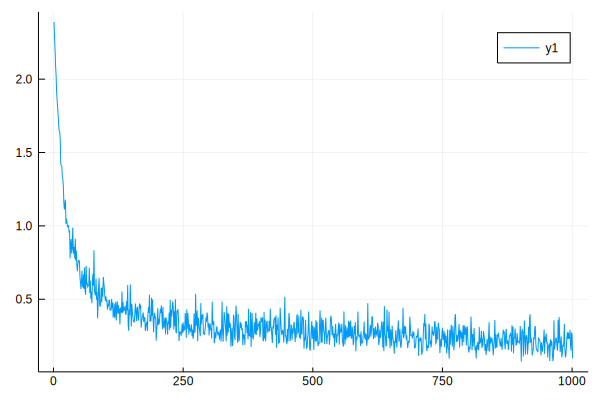

In [65]:
plot(fAdam)

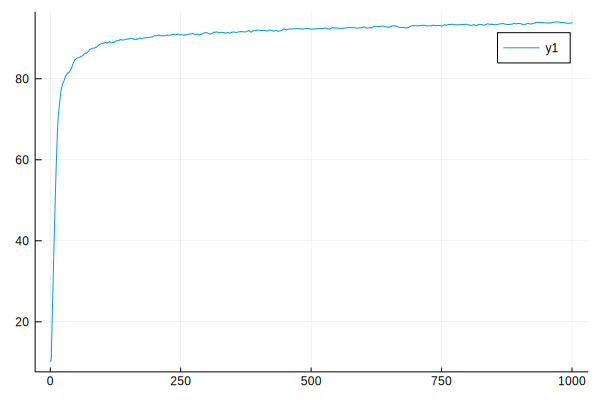

In [66]:
plot(compute_acc(mnist, paramAdam))

In [67]:
#####################################################################################
                            # Test Adam

# definition state
state = Geraldine.AdamState(copy(mnistFlux.x0), sam)
# Parameters
α_adam = 0.001
β_1 = 0.9
β_2 = 0.999
# Algo definition
algo = AdamConstStep(α_adam, β_1, β_2)
# Creation test
accAdam = Accum_1st()

state, accumulatorAdam = algo(mnistFlux, state ; sp = sp, accumulator = accAdam, verbose = verbose);

Algorithm of type : AdamConstStep{Float64}
nmaxReached


In [68]:
resultAdam = Geraldine.structToDict(accumulatorAdam)

paramAdam = resultAdam[:ParamAccumulator]
fAdam = resultAdam[:ValueAccumulator];

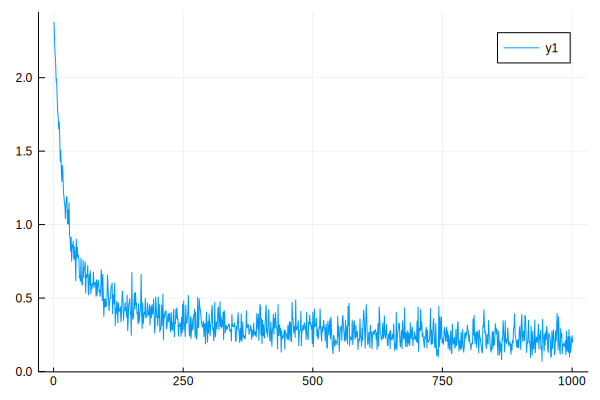

In [69]:
plot(fAdam)

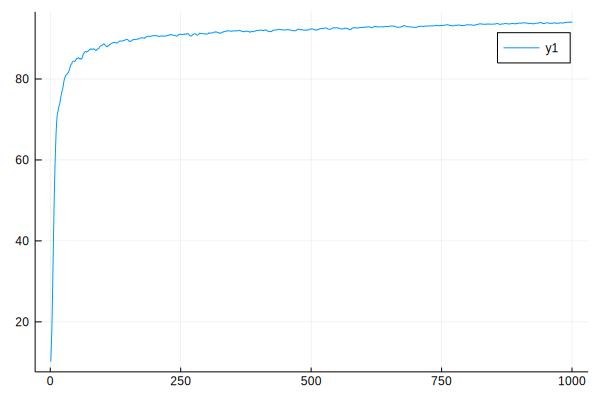

In [70]:
plot(compute_acc(mnistFlux, paramAdam))

In [71]:
#####################################################################################
                            # Test SGD

sp = Geraldine.StopParam(;NMax = 2000, TMax = TMax, eps_g = epsOptimisation);

# definition state
state = Geraldine.SGDState(copy(mnist.x0), sam)
# Parameters
α_sgd = 0.0001

# Algo definition
algo = SGDConstStep(α_sgd)
# Creation test
acc = Accum_1st()

state, accumulatorSGD = algo(mnist, state ; sp = sp, accumulator = acc, verbose = verbose);

Algorithm of type : SGDConstStep{Float64}
nmaxReached


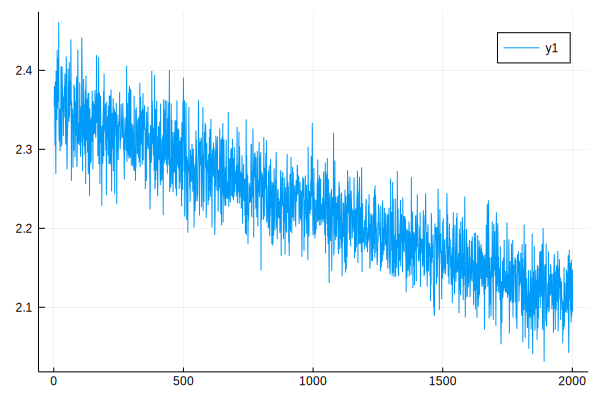

In [72]:
resultSGD = Geraldine.structToDict(accumulatorSGD)

paramSGD = resultSGD[:ParamAccumulator]
fSGD = resultSGD[:ValueAccumulator];

plot(fSGD)

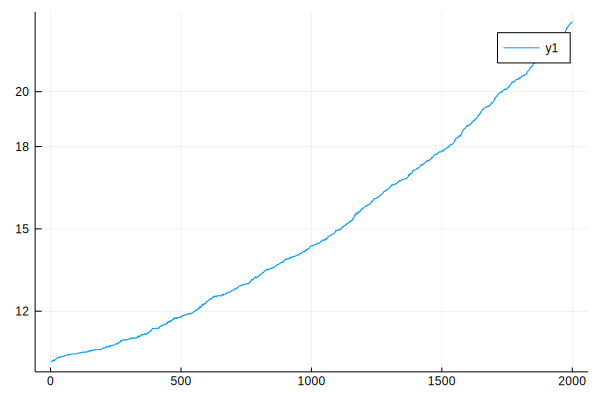

In [73]:
plot(compute_acc(mnist, paramSGD))

In [74]:
#####################################################################################
                            # Test SGD

# definition state
state = Geraldine.SGDState(copy(mnistFlux.x0), sam)
# Parameters
α_sgd = 0.001

# Algo definition
algo = SGDConstStep(α_sgd)
# Creation test
acc = Accum_1st()

state, accumulatorSGD = algo(mnistFlux, state ; sp = sp, accumulator = acc, verbose = verbose);

Algorithm of type : SGDConstStep{Float64}
nmaxReached


(SGDState{Float32,RandomSampling}(2000, 1.0708852f0, Float32[0.07854602, -0.08330545, 0.059533905, -0.0514242, -0.079662375, -0.0035739979, 0.057793055, -0.05778395, 0.03380301, -0.022970082  …  0.029160123, -0.00612486, -0.0028271878, -0.0007526989, 0.014327646, -0.010118579, 0.005630975, -0.011190345, -0.00044883366, -0.01765622], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.026712691, 0.00365174, 0.017745048, 0.008587564, 0.022708878, -0.0054596467, -0.00033729136, 0.007197365, -0.017646825, -0.009734142], RandomSampling(100, 60000, [55962, 47140, 47568, 45341, 32061, 35822, 55156, 35466, 15592, 54941  …  4710, 48571, 54652, 42713, 22726, 35807, 51236, 26374, 59646, 42230]), 8.21046987274e13, 8.2136832003e13), Accumulator(AbstractAccumulator[ValueAccumulator([2.340592384338379, 2.3303682804107666, 2.350856065750122, 2.327155351638794, 2.368399143218994, 2.3375861644744873, 2.3843019008636475, 2.3179244995117188, 2.3597872257232666, 2.3498010635375977  …  1.1750400

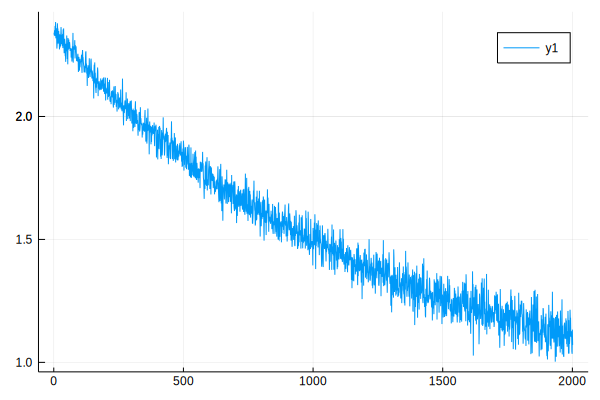

In [75]:
resultSGD = Geraldine.structToDict(accumulatorSGD)

paramSGD = resultSGD[:ParamAccumulator]
fSGD = resultSGD[:ValueAccumulator];

plot(fSGD)

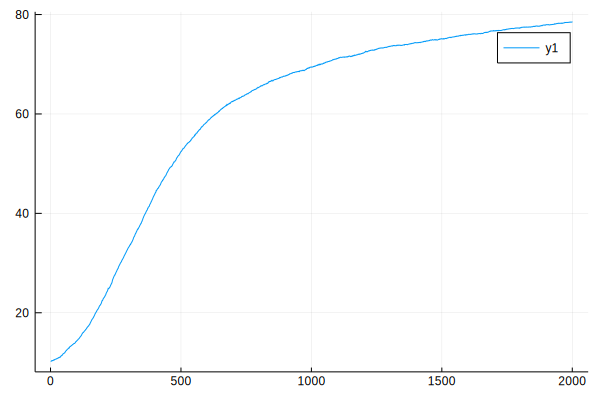

In [76]:
plot(compute_acc(mnist, paramSGD))

In [141]:
##############################################################################
TYPE = Float64

#####################################################################################
# Optimisation
verbose = true

IterMax = 20 # Nombre iterations maximales
TMax = 1800.0 # Temps max en secondes
epsilonOptimisation = 10^(-4) # Precision norme gradient

# Sampling init
N0 = 100
NMin = 50
increment = 1;

# subSampling
coeff_bhhh = 0.25
maxBhhh = 2500
subSampling = ConstantCoeffSubSampling(maxBhhh, coeff_bhhh)

#btrCoeffs = Geraldine.BTRDefaults() # avec 4*‖s‖
btrCoeffs = Geraldine.BTRCoeffs() # avec expension de γ_3 pour iteration tres reussie


Geraldine.BasicTrustRegionWithCoeff{Float64}(0.01, 0.8, 0.5, 0.9, 1.5)

In [142]:
Accum_2nd_full() = Accumulator(Value(), Iter(),
                FieldAccumulator{Float64}(:fcand), Delta(), Times(), SamplingSizeAccumulator(), 
                FieldAccumulator{Float64}(:mu), 
                FieldAccumulator{Float64}(:ρ), NStep(), FieldAccumulator{Float64}(:iterCG), IsAcceptedAccumulator(), Param())

Accum_2nd_tv() = Accumulator(Value(), Iter(),
                FieldAccumulator{Float64}(:fcand), Delta(), Times(), SamplingSizeAccumulator(), 
                FieldAccumulator{Float64}(:mu), FieldAccumulator{Float64}(:sHs) ,
                FieldAccumulator{Float64}(:ρ),  FieldAccumulator{Float64}(:iterCG), IsAcceptedAccumulator(), Param())

Accum_2nd_sHs() = Accumulator(Value(), Iter(),
                FieldAccumulator{Float64}(:fcand), Delta(), Times(), SamplingSizeAccumulator(), 
                FieldAccumulator{Float64}(:mu),  FieldAccumulator{Float64}(:sHs) ,
                FieldAccumulator{Float64}(:ρ),  FieldAccumulator{Float64}(:iterCG), IsAcceptedAccumulator(), Param())

Accum_2nd_sHs (generic function with 2 methods)

In [143]:
function Sofia.Hdotv!(beta::AbstractVector{T}, mo::MnistModel, v::AbstractVector, ac::Array{T, 1};
        sample = 1:length(mo.data)) where {T, UPD, D}
    ac[:] = HessianBackpropagation(mo.network, beta, v, sample) 
end


function Sofia.Hdotv(beta::AbstractVector{T}, mo::MnistModel, v::AbstractVector;
        sample = 1:length(mo.data)) where {T, UPD, D}
    return HessianBackpropagation(mo.network, beta, v, sample) 
end

In [144]:
##############################################################################
                                # Test Hessian / True Var 

# Hessian
Hessian = Geraldine.UncomputedHessian{TYPE}

# Smoothing
smoothing = Geraldine.NaiveSmoothing()
# --- Sampling
varStrategy = Geraldine.TrueVar{Float64}(smoothing)

# --- Sampling
subSampling = ConstantCoeffSubSampling(maxBhhh, coeff_bhhh)
samplingStrategy = Geraldine.DynamicSampling{Geraldine.IndComRN}(Sofia.Nobs(mnist), varStrategy, 
                                                                    NMin = NMin, N0=N0, 
                                                                    increment=increment, 
                                                                    subSampling=subSampling)

# BTR
accBtr =  Accum_2nd_tv()

sp = Geraldine.StopParam(;NMax = IterMax, TMax = TMax, eps_g = epsOptimisation);

btr =  Geraldine.BTRStruct(sp; Hessian = Hessian,  sam=typeof(samplingStrategy))

state, accumulatorHEStv = btr(mnist, copy(mnist.x0) , samplingStrategy, accumulator = accBtr, verbose = verbose)

--- Iteration 0 (selected SAM) : 
------ Classic btr ---------- : 
 --- sampling : Geraldine.DynamicSampling{Geraldine.IndComRN,Int64}
-------------------------
initializeState! AbstractStochasticModel -- Classic
initializeSampling Geraldine.DynamicSampling{Geraldine.IndComRN,Int64}! Ind / Com RN
compute gradient for Classic
-------  updatePreviousValues  True Var --------
-------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 1.5192937659488932 and ϵ = 1.0000000000000004e-6

Iteration 0 -> 1
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
Hessian Backpropagation : 
  sample = 25
l = 3
(10, 25)
(10, 25)
(10, 100)
-----
(10, 25)
(10, 25)


LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 25 and 100")[39m

In [ ]:
# Collecting results
resultHEStv = Geraldine.structToDict(accumulatorHEStv)

plot(resultHESfull[:SamplingSizeAccumulator][1])

In [77]:
################################################################################
#                       Functions on Model
################################################################################

function F_train(x::AbstractVector{T}, model::MnistModel; sample::AbstractVector{Int64} = 1:nInd) where T
        instanciate(x, model.network)
   return model.network(model.train_data, 1:nInd)
end

function F_test(x::AbstractVector{T}, model::MnistModel; sample::AbstractVector{Int64} = 1:nInd_tst) where T
    instanciate(x, model.network)
    return  model.network(model.test_data, 1:nInd_tst)
end

## Calcul des valeurs f_train / f_test on every parameter sets

function compute_ftest(array_parameters::Array{Vector{T}, 1}, model::MnistModel) where T
    f_test = T[]
    for i in 1:length(array_parameters)
        push!(f_test, F_test(array_parameters[i], model))
    end
    return f_test
end

function compute_ftrain(array_parameters::Array{Vector{T}, 1}, model::MnistModel) where T
    f_full_train = T[]
    for i in 1:length(array_parameters)
        push!(f_full_train, F_train(array_parameters[i], model))
    end
    return f_full_train
end

## calcul des accuracy on FULL train set and FULL test set
function compute_acc(model::AbstractChain, x_data, y_data, array_parameters)
    acc = []
    for i in 1:length(array_parameters)
        instanciate(array_parameters[i], model)
        (t, n) = accuracy(model(x_data), y_data; dims=1, average=false)
        push!(acc, t/n*100)
    end
    return acc
end

function computeAccTrain(mo::MnistModel, data_exp)
    acc_train = compute_acc(mo.network, mo.train_data.x , mo.train_data.y, data_exp.ParamAccumulator)
    return acc_train
end

function computeAccTest(mo::MnistModel, data_exp)
    acc_test = compute_acc(mo.network, mo.test_data.x , mo.test_data.y, data_exp.ParamAccumulator)
    return acc_test
end


LoadError: [91mUndefVarError: AbstractChain not defined[39m